In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

CommonLiteracyBertModels.ipynb		    CommonLiteracy_CNN_Model.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D.ipynb  Dataset
Common_Literacy_BOW_TFIDF_AVGW2V300D.ipynb


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [ ]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [ ]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [ ]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

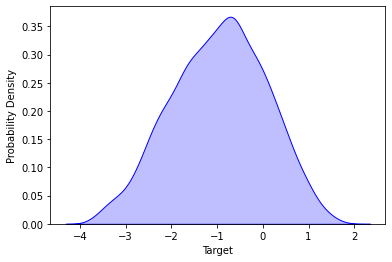

In [ ]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [ ]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

### Pretrained Glove Vector assignment

In [ ]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

# !wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

In [ ]:
#unzip the downloaded glove vectors to drive
# !unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

glove_100d = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_100d[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_100d))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_100d.keys())

In [ ]:
# checking the dictionary word shape
print(glove_100d['the'].shape)

(100,)


In [ ]:
# code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_100d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

Dictionary limited by K is : {'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526

### Cleaning the text data for any special characters and numerical characters

In [ ]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    return phrase

In [ ]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 2144.06it/s]


In [ ]:
# print(df_train['excerpt'].values[0])
# print("="*100)
# print(df_train['cleaned_excerpt'].values[:100])

In [ ]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [ ]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(100) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_100d[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
      # avgW2V_dict[sentence] = vector
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array


### Latent Dirichlet Allocation

In [ ]:
lda_vectorizer = CountVectorizer()
corpus = lda_vectorizer.fit_transform(df_train['cleaned_excerpt'])
feature_names = lda_vectorizer.get_feature_names()
print(corpus.shape)
print(feature_names)

lda_model = LDA(n_components=6,max_iter=20,random_state=20)
X_topics = lda_model.fit_transform(corpus)
topic_words = lda_model.components_

(2834, 26660)
['00', '000', '000th', '001', '02', '03', '034', '04', '049', '06', '07', '070', '090', '0v', '10', '100', '1000', '100lbs', '1011', '1012', '1016', '1024', '105', '1050', '106', '108', '1095', '10am', '10th', '10x10', '11', '111', '112', '115', '1154', '116', '11a', '11and', '11b', '11th', '12', '120', '1200', '1223', '125', '127', '128', '129', '1291', '1299', '12th', '12x13', '13', '130', '1305', '132', '1328', '1337', '1340', '136', '1362', '1389', '13th', '13x14', '14', '140', '141', '1425', '142nd', '143', '1439', '144', '1453', '148', '149', '1490s', '1492', '1496', '14th', '15', '150', '1501', '1506', '1513', '1519', '1524', '1528', '1536', '1556', '156', '1580', '1585', '1592', '1598', '15th', '16', '1600', '1600s', '1607', '1608', '1610', '1613', '1615', '1624', '165', '1651', '1652', '165546', '167', '1670', '1683', '1688', '1699', '16ft', '16s', '16th', '17', '1700', '1700s', '1701', '1705', '171', '1710', '173', '1734', '1754', '1756', '1757', '1759', '1760',

In [ ]:
n_top_words = 4

for i, topic_dist in enumerate(topic_words):
  print(topic_dist)
  sorted_topic_dist = np.argsort(topic_dist)
  print("="*100)
  print(sorted_topic_dist)
  topic_words_new = np.array(feature_names)[sorted_topic_dist]
  topic_words_new = topic_words_new[:-n_top_words:-1]
  print("Topic",str(i+1),topic_words_new)

[ 0.16674001 70.08362254  0.16666674 ...  0.16666668  1.16108188
  0.16666674]
[ 3141 24297 24298 ... 10776 17501 16629]
Topic 1 ['one' 'people' 'great']
[3.1657928  0.16734336 0.16805114 ... 0.1666667  0.16666686 0.16666678]
[ 3141 24297 24298 ... 20404 24812 16629]
Topic 2 ['one' 'two' 'room']
[0.16666679 0.1674839  0.16666684 ... 4.16647702 0.16666696 0.16666685]
[24297 24298  6202 ... 26429 14149 16629]
Topic 3 ['one' 'little' 'would']
[ 0.16736111 90.27994246  2.16528173 ...  0.16666668  0.17225059
  0.16666673]
[ 3141  6202  7035 ...  6991  1265 25285]
Topic 4 ['used' 'also' 'different']
[0.1667725  0.16685787 0.16666672 ... 0.1668562  0.16666675 1.16666606]
[ 3141 24297 24298 ... 16629 14149 20638]
Topic 5 ['said' 'little' 'one']
[0.16666678 4.13474987 0.16666684 ... 0.16666671 0.16666695 0.16666684]
[ 3141 17277 16663 ... 14497 14030 16629]
Topic 6 ['one' 'like' 'made']


### Splitting data into Train and cross validation(or test): Stratified Sampling

In [ ]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [ ]:
print(X_train.head(5))

2793    aerodynamics greek dynamics branch fluid dynam...
316     cuneiform script one earliest known systems wr...
2133    american government tradition though recent on...
2082    figures boat strong man ragged grizzled hair s...
127     happened worcester captain biffen house also b...
Name: cleaned_excerpt, dtype: object


### TF-IDF processing of text

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_tfidf = vectorizer.transform(X_train)
X_test_excerpt_tfidf = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf.shape, Y_train.shape)
print(X_test_excerpt_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 5584) (1898,)
(936, 5584) (936,)


### Bag of Words 

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_bow = vectorizer.transform(X_train)
X_test_excerpt_bow = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_bow.shape, Y_train.shape)
print(X_test_excerpt_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 5584) (1898,)
(936, 5584) (936,)


### Average Word to Vector Representation for 100 dimension

In [ ]:
X_train_excerpt_avgw2v = Avg_W2V(X_train)
X_test_excerpt_avgw2v = Avg_W2V(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avgw2v.shape, Y_train.shape)
print(X_test_excerpt_avgw2v.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:00<00:00, 3631.04it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


# Various Models

### Linear Regression

In [ ]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_tfidf, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_tfidf,Y_train)

Y_pred = lr.predict(X_test_excerpt_tfidf)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.32805193 0.27987259 0.24219322 0.3976102  0.23925806] 0.2973972014187799 0.05952664893817814
This is root mean square error:  0.9110678565016714


In [ ]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_bow, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_bow,Y_train)

Y_pred = lr.predict(X_test_excerpt_bow)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.17554906 0.13979032 0.09712838 0.28079012 0.09840082] 0.15833174179229256 0.06778471830820666
This is root mean square error:  0.994041933660022


### Function to run all models together

In [ ]:
data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}

def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.2min finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.6631730387565513
Root Mean squared Error Test for Bag of Words:  0.8289331748780853


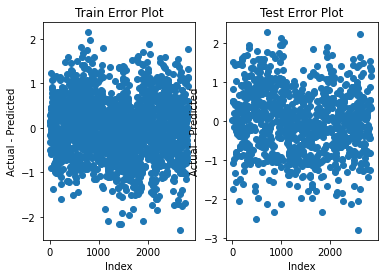

 33%|███▎      | 1/3 [01:13<02:27, 73.83s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.9s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.6672610543185127
Root Mean squared Error Test for TF-IDF:  0.8313356705028145


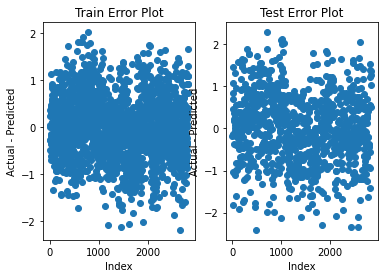

 67%|██████▋   | 2/3 [01:21<00:53, 53.96s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0532s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1561s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1258s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6690455216618219
Root Mean squared Error Test for Avg Word2Vec:  0.7080053841103959


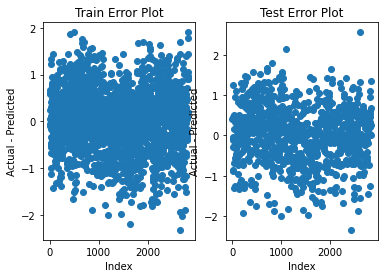

100%|██████████| 3/3 [01:22<00:00, 27.48s/it]


In [ ]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0761s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1810s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.1s finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
Ridge(alpha=20.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.2421689930079709
Root Mean squared Error Test for Bag of Words:  0.8546840991705531


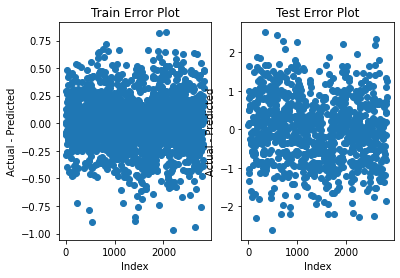

 33%|███▎      | 1/3 [00:02<00:04,  2.40s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0380s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0983s.) Setting batch_size=4.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1523s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
Ridge(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.4022471821610731
Root Mean squared Error Test for TF-IDF:  0.7787426400781111


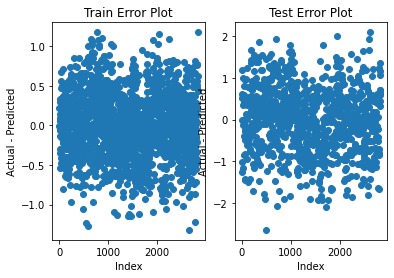

 67%|██████▋   | 2/3 [00:03<00:02,  2.06s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0474s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0265s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0576s.) Setting batch_size=8.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1119s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
Ridge(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6679241452109789
Root Mean squared Error Test for Avg Word2Vec:  0.7057599527686609


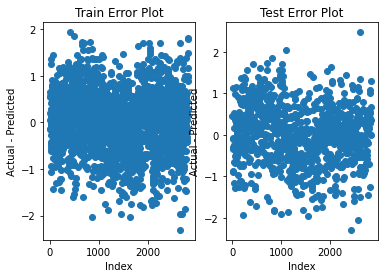

100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


In [ ]:
ridge_params = {'alpha':[0.35,0.4,0.5,0.6,0.8,1.0,1.5,2.0,3.0,4>0,5.0,6.0,10.0,15.0,20.0]}
ridge = Ridge()

modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1078s.) Setting batch_size=2.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1958s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.8s finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
SGDRegressor(alpha=0.1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.5875784940176587
Root Mean squared Error Test for Bag of Words:  0.8575985416948142


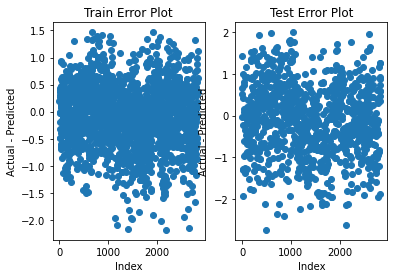

 33%|███▎      | 1/3 [00:03<00:06,  3.10s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.5s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.8330358194896688
Root Mean squared Error Test for TF-IDF:  0.9134027314720762


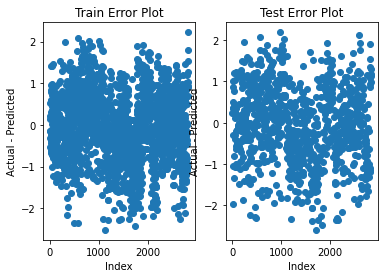

 67%|██████▋   | 2/3 [00:08<00:03,  3.93s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1176s.) Setting batch_size=2.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1957s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  67 out of  70 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.5s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.7069238315701302
Root Mean squared Error Test for Avg Word2Vec:  0.7375351913869493


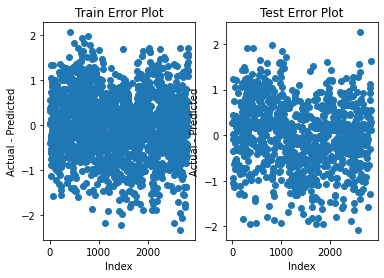

100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


In [ ]:
SGD_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1560s.) Setting batch_size=2.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1887s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.9s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Bag of Words:  1.0343799425647653
Root Mean squared Error Test for Bag of Words:  1.0640567518182547


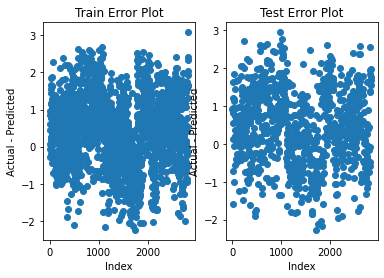

 33%|███▎      | 1/3 [00:02<00:05,  2.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0900s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1892s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for TF-IDF:  0.8135469471515991
Root Mean squared Error Test for TF-IDF:  0.8564607819054422


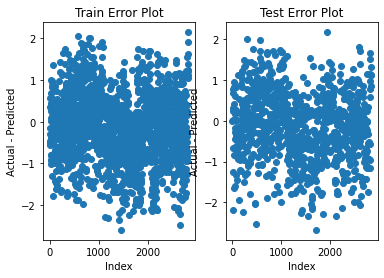

 67%|██████▋   | 2/3 [00:05<00:02,  2.60s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.7174175818146702
Root Mean squared Error Test for Avg Word2Vec:  0.7687474778558888


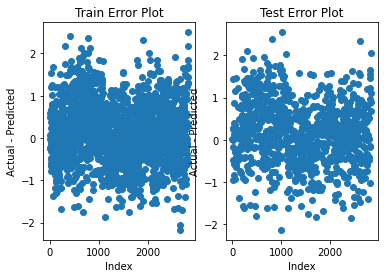

100%|██████████| 3/3 [00:12<00:00,  4.16s/it]


In [ ]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.09732723141102399
Root Mean squared Error Test for Bag of Words:  0.9429076033457615


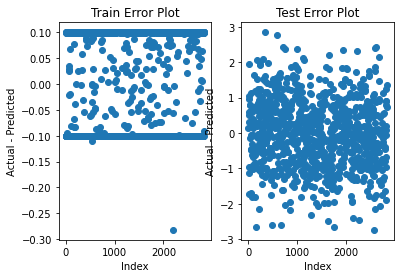

 33%|███▎      | 1/3 [01:09<02:18, 69.49s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   52.0s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.49990796667533116
Root Mean squared Error Test for TF-IDF:  0.7802677458079039


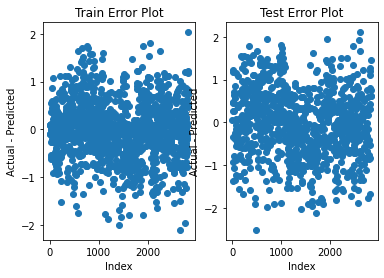

 67%|██████▋   | 2/3 [02:07<01:06, 66.04s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.6s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SVR(C=0.2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6708196698167369
Root Mean squared Error Test for Avg Word2Vec:  0.7095595198836383


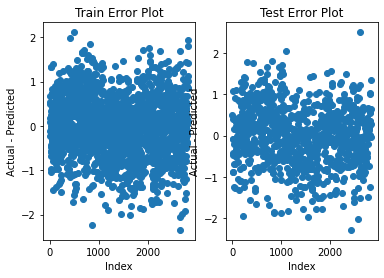

100%|██████████| 3/3 [02:21<00:00, 47.23s/it]


In [ ]:
SVR_params = {'C':[0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0]}
LinearSVR = SVR(kernel='linear')

modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.9min finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.5716801749907403
Root Mean squared Error Test for Bag of Words:  0.795705086779705


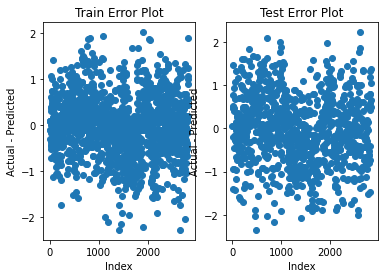

 33%|███▎      | 1/3 [01:59<03:58, 119.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.7min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.5637343598309339
Root Mean squared Error Test for TF-IDF:  0.7862416938750422


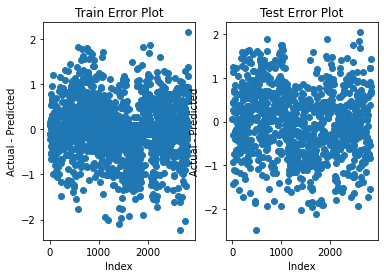

 67%|██████▋   | 2/3 [03:44<01:54, 114.87s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   51.4s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SVR(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.5682268032927112
Root Mean squared Error Test for Avg Word2Vec:  0.6871670948497609


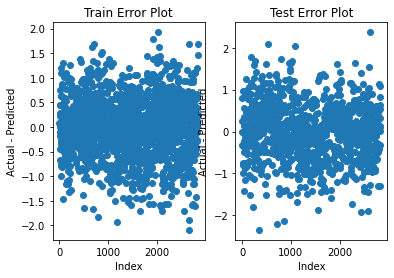

100%|██████████| 3/3 [04:38<00:00, 92.73s/it]


In [ ]:
SVR_params = {'C':[10.0,20,30,50,80,100,150,200,300,400,500,600,700,900,1000]}
RBF_SVR = SVR(kernel='rbf',gamma="auto")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 10.4min finished


----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.3079286326935793
Root Mean squared Error Test for Bag of Words:  0.855187670682365


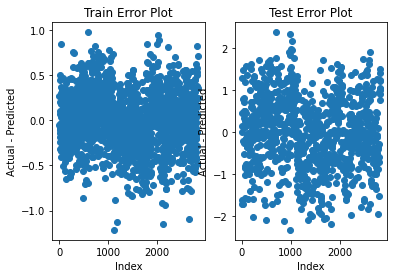

 33%|███▎      | 1/3 [11:27<22:54, 687.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 11.2min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.3183413577571014
Root Mean squared Error Test for TF-IDF:  0.863311096973893


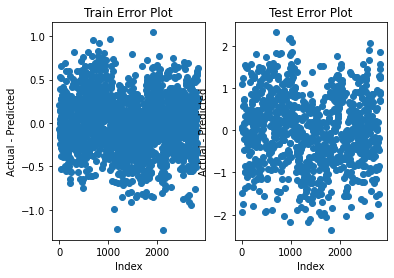

 67%|██████▋   | 2/3 [23:13<11:32, 692.94s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.1min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.26996148423655425
Root Mean squared Error Test for Avg Word2Vec:  0.7283206069559836


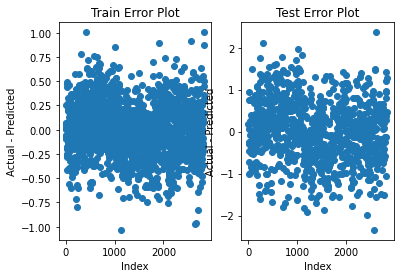

100%|██████████| 3/3 [25:28<00:00, 509.63s/it]


In [ ]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
modelfunction(RandomForest,data,Y_train,Y_test,RF_params)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


[12:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Bag of Words: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Bag of Words:  0.604419709817361
Root Mean squared Error Test for Bag of Words:  0.8430772782960204


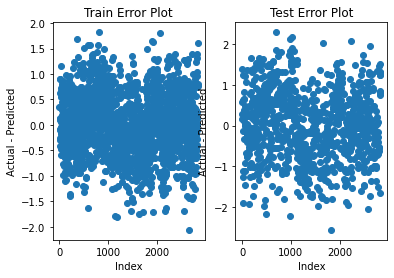

 33%|███▎      | 1/3 [01:20<02:41, 80.69s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished


[12:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.5681815411529392
Root Mean squared Error Test for TF-IDF:  0.8586639691154326


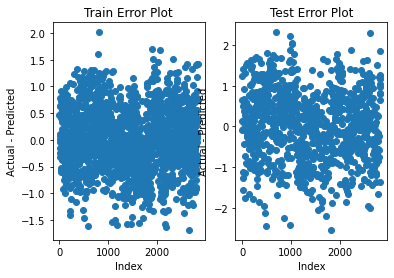

 67%|██████▋   | 2/3 [03:22<01:32, 92.88s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


[12:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.3983745995738452
Root Mean squared Error Test for Avg Word2Vec:  0.7010456072915522


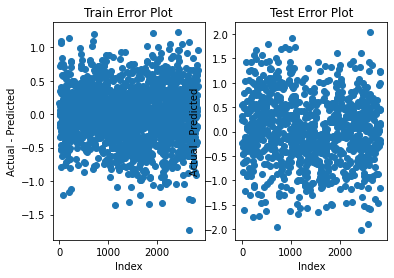

100%|██████████| 3/3 [04:25<00:00, 88.57s/it]


In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
modelfunction(xgb,data,Y_train,Y_test,xgb_params)